In [ ]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

In [ ]:
apply_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])
BatchSize = 100 # change according to system specs

trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

# Validation set with random rotations in the range [-90,90]
testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

In [ ]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))

No. of samples in train set: 60000
No. of samples in test set: 10000


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [ ]:
use_gpu = torch.cuda.is_available()
net = LeNet()
print(net)
if use_gpu:
    print('GPU is avaialble!')
    net = net.cuda()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
import torch.optim as optim

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.005,momentum=0)

train_loss=[]
train_acc=[]
criterion = nn.CrossEntropyLoss() 
for epoch in range(10):
    # trainning
    ave_loss = 0
    total_cnt = 0
    correct_cnt=0

    for batch_idx, (x, target) in enumerate(trainLoader):
        optimizer.zero_grad()
        if use_gpu:
            x, target = x.cuda(), target.cuda()
        #x, target = Variable(x), Variable(target)
        out = net(x)
        loss = criterion(out, target)
        ave_loss = ave_loss * 0.9 + loss.data.item() * 0.1
        loss.backward()
        optimizer.step()
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        acc=correct_cnt * 1.0 / total_cnt
        
        
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(trainLoader):
            print ('==>>> epoch: {}, batch index: {}, train loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss,acc))
    train_loss.append(ave_loss)
    train_acc.append(acc)
    

Text(0, 0.5, 'Training')

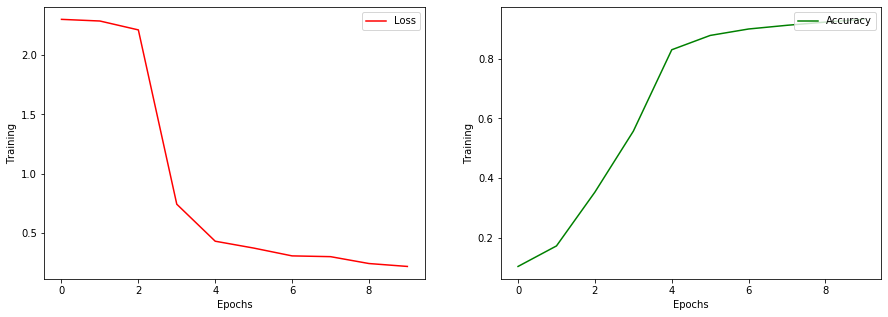

In [ ]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(1,2,1)
plt.plot(range(10),train_loss,'r-',label='Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.subplot(1,2,2)
plt.plot(range(10),train_acc,'g-',label='Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')